# Product level Impact of 3.2 Beer in Kansas

In [1]:
# packages used
import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import statsmodels.formula.api as smf
import scipy.stats as stats
import pylab as pl
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

### Load Store Data

In [2]:
#load the All stores in Kansas
All_Stores_Kansas = pd.read_csv('AllStoresKansas.csv')
All_Stores_Kansas = All_Stores_Kansas.rename(columns = {'WJXBFS1':'PROD_DEPLETION'})
All_Stores_Kansas.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION
0,103946193,CORONA EX 18PK BT,OFF,84.750
1,101537249,CORONA EX 3.2 24OZ BT,OFF,32.000
2,107443744,PACIFICO 6PK BT,OFF,10.000
3,200572989,CORONA EX 3.2 6PK BT,OFF,22.000
4,101476216,CORONITA 7OZ 6PK BT,OFF,153.418


In [3]:
#clean data

#remove NA Depletion 
All_Stores_Kansas = All_Stores_Kansas.loc[All_Stores_Kansas['PROD_DEPLETION'].notnull(),:]

#remove Negative Depletion
All_Stores_Kansas = All_Stores_Kansas.loc[All_Stores_Kansas['PROD_DEPLETION'] > 0.0,:] 
All_Stores_Kansas.shape

(33000, 4)

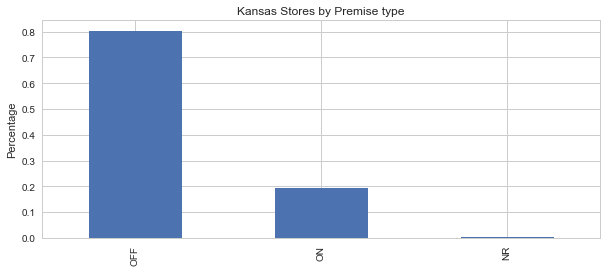

In [9]:
# Kansas Stores by Premise type
premise_type = All_Stores_Kansas.loc[:,'RTL_PREMISE_TYPE_CD']
premise_type = premise_type.value_counts()/len(premise_type)
ax = premise_type.plot.bar(figsize=(10,4), title = 'Kansas Stores by Premise type')
ax.set_ylabel("Percentage");

### Load Product Data for On-Premise

In [5]:
LowPointOn = pd.read_csv('KansasLowPointOnProducts.csv')
Top5LowPointOn = LowPointOn.head(7)['ITEM_MASTER_SKU_DSC']
Top5LowPointOn

0       CORONA EX 3.2 6PK BT
1      CORONA EX 3.2 12PK BT
2          CORONA LT 18PK BT
3      MODELO ESP 3.2 6PK BT
4     MODELO ESP 3.2 12PK BT
5    CORONA LIGHT 1/2 BL KEG
6    MODELO ESP 3.2 12PK CAN
Name: ITEM_MASTER_SKU_DSC, dtype: object

In [6]:
#select top 5 products that are comparable:
Top5LowPointOn = Top5LowPointOn[[0,1,3,4,6]]
#put the products and their pairs into datafame
Top5_LowPoint_On_Pairs_DF = pd.DataFrame(Top5LowPointOn).reset_index(drop=True)
Top5_LowPoint_On_Pairs_DF['PAIRS'] = ['CORONA EX 6PK BT', 'CORONA EX 12PK BT', 'MODELO ESP 6PK BT', 'MODELO ESP 12PK BT', 'MODELO ESP 12PK CAN']
Top5_LowPoint_On_Pairs_DF

,ITEM_MASTER_SKU_DSC,PAIRS
0,CORONA EX 3.2 6PK BT,CORONA EX 6PK BT
1,CORONA EX 3.2 12PK BT,CORONA EX 12PK BT
2,MODELO ESP 3.2 6PK BT,MODELO ESP 6PK BT
3,MODELO ESP 3.2 12PK BT,MODELO ESP 12PK BT
4,MODELO ESP 3.2 12PK CAN,MODELO ESP 12PK CAN


In [8]:
BeerList_On = list(Top5_LowPoint_On_Pairs_DF['ITEM_MASTER_SKU_DSC']) + list(Top5_LowPoint_On_Pairs_DF['PAIRS'])
BeerList_On

['CORONA EX 3.2 6PK BT',
 'CORONA EX 3.2 12PK BT',
 'MODELO ESP 3.2 6PK BT',
 'MODELO ESP 3.2 12PK BT',
 'MODELO ESP 3.2 12PK CAN',
 'CORONA EX 6PK BT',
 'CORONA EX 12PK BT',
 'MODELO ESP 6PK BT',
 'MODELO ESP 12PK BT',
 'MODELO ESP 12PK CAN']

### Analysis for On-Premise

In [12]:
#Subset On-premise stores 
Top5_On_pairs_stores = All_Stores_Kansas.loc[All_Stores_Kansas['RTL_PREMISE_TYPE_CD'] == 'ON', :]

#Subset On-premise stoers that sell top 5 pairs of beer (10 products)
Top5_On_pairs_stores= Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(BeerList_On)].reset_index(drop=True)

Top5_On_pairs_stores.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION
0,101733532,MODELO ESP 12PK BT,ON,14.0
1,301616936,MODELO ESP 6PK BT,ON,16.0
2,101733587,CORONA EX 12PK BT,ON,7.0
3,103639684,CORONA EX 12PK BT,ON,3.0
4,201725170,MODELO ESP 6PK BT,ON,17.0


In [14]:
len(Top5_On_pairs_stores)

2466

In [15]:
Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].unique()

array(['MODELO ESP 12PK BT', 'MODELO ESP 6PK BT', 'CORONA EX 12PK BT',
       'MODELO ESP 3.2 12PK BT', 'CORONA EX 3.2 12PK BT',
       'MODELO ESP 3.2 6PK BT', 'CORONA EX 3.2 6PK BT', 'CORONA EX 6PK BT',
       'MODELO ESP 3.2 12PK CAN', 'MODELO ESP 12PK CAN'], dtype=object)

In [16]:
#create a graph_DF for explanatory analysis.
graph_DF = Top5_On_pairs_stores
graph_DF['Product'] = graph_DF['ITEM_MASTER_SKU_DSC']
for index in range(len(graph_DF['Product'])):
    if '3.2 ' in graph_DF.loc[index, 'Product']:
        graph_DF.loc[index, 'Product'] = graph_DF.loc[index, 'Product'].replace('3.2 ','')
graph_DF['is32'] = graph_DF['ITEM_MASTER_SKU_DSC'] == graph_DF['Product']        

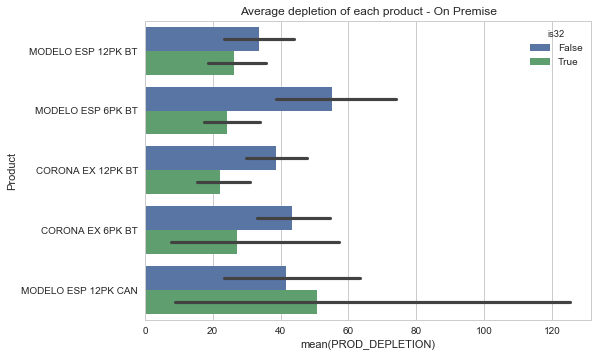

In [17]:
#plot Average depletion of each product for On-premise
plt.title("Average depletion of each product - On Premise")
sns.barplot(x='PROD_DEPLETION', y="Product", hue="is32", data=graph_DF);

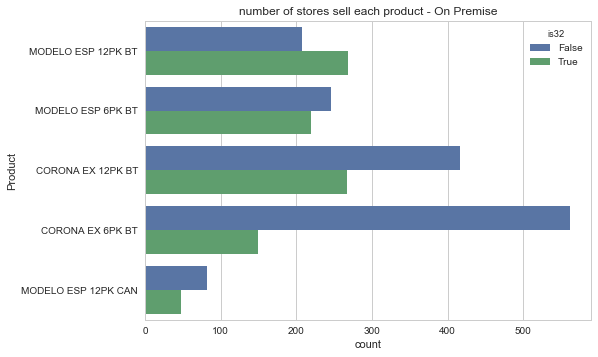

In [18]:
#plot number of stores sell each product for On-premise
plt.title("number of stores sell each product - On Premise")
#sns.barplot(x=graph_DF['Product'].value_counts(),y= graph_DF['Product'], hue=graph_DF["is32"]);
graph = sns.countplot(y='Product', hue="is32", data=graph_DF)
graph.set_yticklabels(graph_DF['Product'].unique(), rotation=0);

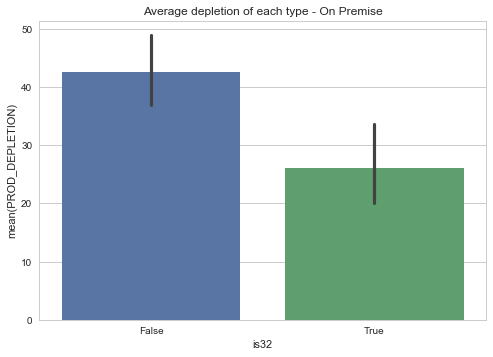

In [21]:
# Average depletion for 3.2 and Non 3.2 products
plt.title("Average depletion of each type - On Premise")
sns.barplot(x='is32', y = 'PROD_DEPLETION', data=graph_DF);

C:\Users\qifan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


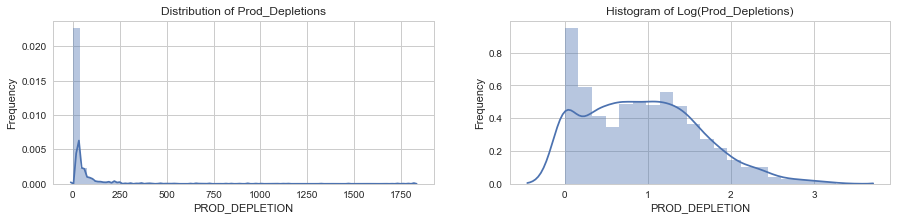

In [23]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title('Distribution of Prod_Depletions')
sns.distplot(Top5_On_pairs_stores['PROD_DEPLETION'])
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.title('Histogram of Log(Prod_Depletions)')
sns.distplot(np.log10(Top5_On_pairs_stores['PROD_DEPLETION'].values))
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency');

## Regression Analysis on Five products for On-premise

In [24]:
#pair1: CORONA EX 3.2 6PK BT vs CORONA EX 6PK BT
subset1 = Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[0, :]))].reset_index(drop=True)
Regression_ON_pair1 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)', data= subset1)
print(Regression_ON_pair1.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.048
Model:                                OLS   Adj. R-squared:                  0.046
Method:                     Least Squares   F-statistic:                     35.53
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):           3.95e-09
Time:                            19:50:42   Log-Likelihood:                -1294.7
No. Observations:                     712   AIC:                             2593.
Df Residuals:                         710   BIC:                             2602.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------

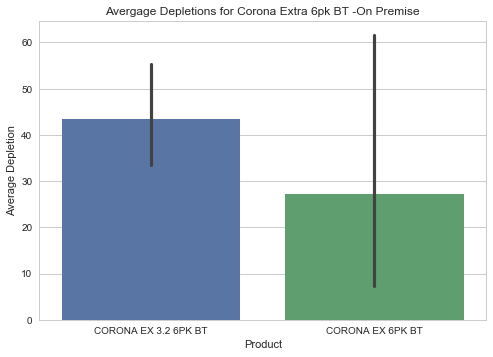

In [28]:
plt.title("Avergage Depletions for Corona Extra 6pk BT -On Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset1)
graph.set(xlabel='Product', ylabel='Average Depletion');

In [ ]:
#maybe add store type

In [30]:
#pair 2: CORONA EX 12PK BT vs CORONA EX 3.2 12PK BT
subset2 = Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[1, :]))].reset_index(drop=True)
Regression_ON_pair2 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)', data= subset2)
print(Regression_ON_pair2.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.007
Model:                                OLS   Adj. R-squared:                  0.005
Method:                     Least Squares   F-statistic:                     4.510
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):             0.0341
Time:                            19:57:31   Log-Likelihood:                -1261.4
No. Observations:                     684   AIC:                             2527.
Df Residuals:                         682   BIC:                             2536.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------

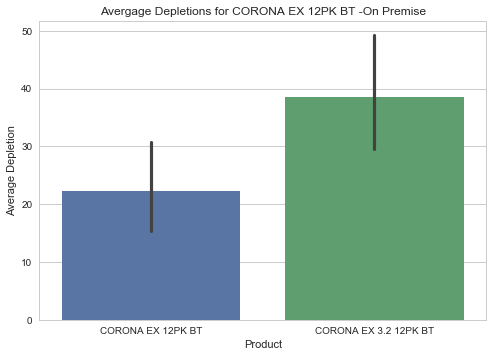

In [32]:
plt.title("Avergage Depletions for CORONA EX 12PK BT -On Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset2)
graph.set(xlabel='Product', ylabel='Average Depletion');

In [33]:
#pair 3: MODELO ESP 3.2 6PK BT vs MODELO ESP 6PK BT
subset3 = Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[2, :]))].reset_index(drop=True)
Regression_ON_pair3 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)', data= subset3)
print(Regression_ON_pair3.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.006
Model:                                OLS   Adj. R-squared:                  0.004
Method:                     Least Squares   F-statistic:                     2.966
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):             0.0857
Time:                            19:58:29   Log-Likelihood:                -865.59
No. Observations:                     465   AIC:                             1735.
Df Residuals:                         463   BIC:                             1743.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------

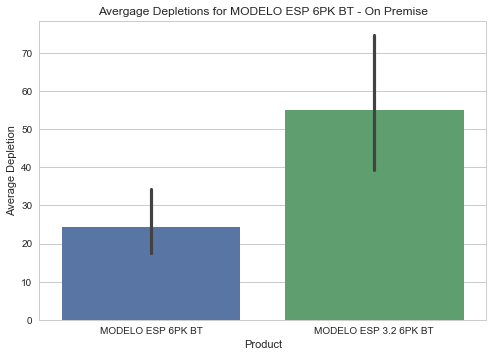

In [34]:
plt.title("Avergage Depletions for MODELO ESP 6PK BT - On Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset3)
graph.set(xlabel='Product', ylabel='Average Depletion');

In [35]:
#pair 4  MODELO ESP 12PK BT vs  MODELO ESP 3.2 12PK BT
subset4 = Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[3, :]))].reset_index(drop=True)
Regression_ON_pair4 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)', data= subset4)
print(Regression_ON_pair4.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                 -0.002
Method:                     Least Squares   F-statistic:                   0.02438
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):              0.876
Time:                            19:59:20   Log-Likelihood:                -900.93
No. Observations:                     476   AIC:                             1806.
Df Residuals:                         474   BIC:                             1814.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------

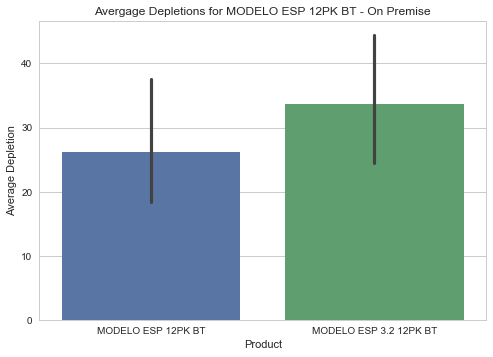

In [36]:
plt.title("Avergage Depletions for MODELO ESP 12PK BT - On Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset4)
graph.set(xlabel='Product', ylabel='Average Depletion');

In [37]:
#pair 5  MODELO ESP 12PK CAN vs MODELO ESP 3.2 12PK CAN
subset5 = Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[4, :]))].reset_index(drop=True)
Regression_ON_pair5 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)', data= subset5)
print(Regression_ON_pair5.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.019
Model:                                OLS   Adj. R-squared:                  0.011
Method:                     Least Squares   F-statistic:                     2.401
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):              0.124
Time:                            20:00:01   Log-Likelihood:                -252.04
No. Observations:                     129   AIC:                             508.1
Df Residuals:                         127   BIC:                             513.8
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------

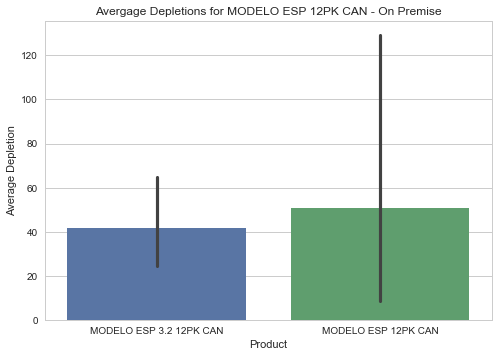

In [38]:
plt.title("Avergage Depletions for MODELO ESP 12PK CAN - On Premise")
graph = sns.barplot(x ='ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset5)
graph.set(xlabel='Product', ylabel='Average Depletion');

### Load Product Data for Off-Premise

In [39]:
#load the product data for Off Premise 
LowPointOff = pd.read_csv('KansasLowPointOffProducts.csv')
Top5LowPointOff = LowPointOff.head(10)['ITEM_MASTER_SKU_DSC']
Top5LowPointOff

0      CORONA EX 3.2 12PK BT
1          CORONA LT 12PK BT
2       CORONA EX 3.2 6PK BT
3    MODELO ESP 3.2 12PK CAN
4           CORONA LT 6PK BT
5           VICTORIA 12PK BT
6          CORONA LT 18PK BT
7      CORONA EX 3.2 18PK BT
8      MODELO ESP 3.2 6PK BT
9    MODELO CHELADA 24OZ CAN
Name: ITEM_MASTER_SKU_DSC, dtype: object

In [40]:
#select top 5 products that are comparable:
Top5LowPointOff = Top5LowPointOff[[0,2,3,7,8]]
#put the products and their pairs into datafame
Top5_LowPoint_Off_Pairs_DF = pd.DataFrame(Top5LowPointOff).reset_index(drop=True)
Top5_LowPoint_Off_Pairs_DF['PAIRS'] = ['CORONA EX 12PK BT', 'CORONA EX 6PK BT', 'MODELO ESP 12PK CAN', 'CORONA EX 18PK BT', 'MODELO ESP 6PK BT']
Top5_LowPoint_Off_Pairs_DF

,ITEM_MASTER_SKU_DSC,PAIRS
0,CORONA EX 3.2 12PK BT,CORONA EX 12PK BT
1,CORONA EX 3.2 6PK BT,CORONA EX 6PK BT
2,MODELO ESP 3.2 12PK CAN,MODELO ESP 12PK CAN
3,CORONA EX 3.2 18PK BT,CORONA EX 18PK BT
4,MODELO ESP 3.2 6PK BT,MODELO ESP 6PK BT


In [41]:
BeerList_Off = list(Top5_LowPoint_Off_Pairs_DF['ITEM_MASTER_SKU_DSC']) + list(Top5_LowPoint_Off_Pairs_DF['PAIRS'])
BeerList_Off

['CORONA EX 3.2 12PK BT',
 'CORONA EX 3.2 6PK BT',
 'MODELO ESP 3.2 12PK CAN',
 'CORONA EX 3.2 18PK BT',
 'MODELO ESP 3.2 6PK BT',
 'CORONA EX 12PK BT',
 'CORONA EX 6PK BT',
 'MODELO ESP 12PK CAN',
 'CORONA EX 18PK BT',
 'MODELO ESP 6PK BT']

### Analysis for Off-Premise

In [42]:
#Subset Off-premise stores 
Top5_Off_pairs_stores = All_Stores_Kansas.loc[All_Stores_Kansas['RTL_PREMISE_TYPE_CD'] == 'OFF', :]

#Subset Off-premise stoers that sell top 5 pairs of beer (10 products)
Top5_Off_pairs_stores= Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(BeerList_Off)].reset_index(drop=True)

Top5_Off_pairs_stores.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION
0,103946193,CORONA EX 18PK BT,OFF,84.75
1,200572989,CORONA EX 3.2 6PK BT,OFF,22.00
2,107354744,CORONA EX 18PK BT,OFF,353.25
3,101967580,CORONA EX 3.2 6PK BT,OFF,197.00
4,100091971,MODELO ESP 3.2 6PK BT,OFF,63.00


In [43]:
len(Top5_Off_pairs_stores)

8285

In [44]:
Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].unique()

array(['CORONA EX 18PK BT', 'CORONA EX 3.2 6PK BT',
       'MODELO ESP 3.2 6PK BT', 'CORONA EX 3.2 12PK BT',
       'CORONA EX 12PK BT', 'MODELO ESP 6PK BT', 'MODELO ESP 12PK CAN',
       'CORONA EX 6PK BT', 'MODELO ESP 3.2 12PK CAN',
       'CORONA EX 3.2 18PK BT'], dtype=object)

In [63]:
#create a graph_DF for explanatory analysis.
graph_DF = Top5_Off_pairs_stores
graph_DF['Product'] = graph_DF['ITEM_MASTER_SKU_DSC']
for index in range(len(graph_DF['Product'])):
    if '3.2 ' in graph_DF.loc[index, 'Product']:
        graph_DF.loc[index, 'Product'] = graph_DF.loc[index, 'Product'].replace('3.2 ','')
graph_DF['is32'] = graph_DF['ITEM_MASTER_SKU_DSC'] == graph_DF['Product']  

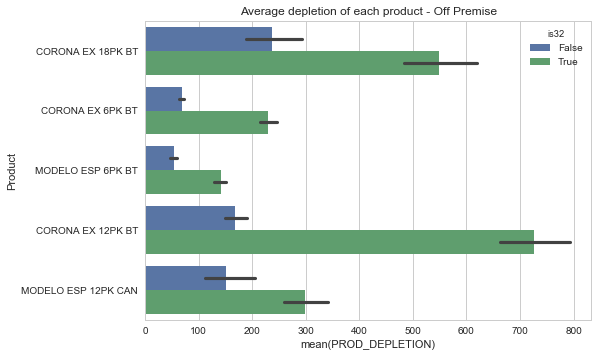

In [65]:
#plot Average depletion of each product for Off-premise
plt.title("Average depletion of each product - Off Premise")
sns.barplot(x='PROD_DEPLETION', y="Product", hue="is32", data=graph_DF);

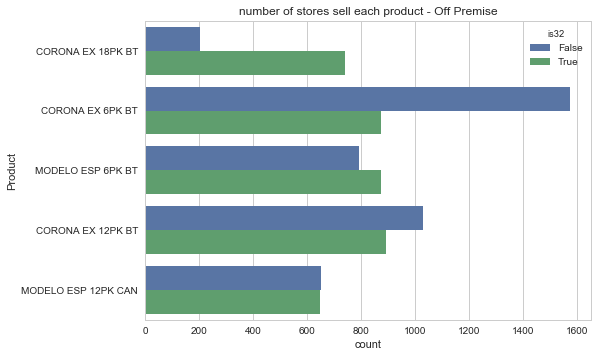

In [66]:
#plot number of stores sell each product for Off-premise
plt.title("number of stores sell each product - Off Premise")
graph = sns.countplot(y='Product', hue="is32", data=graph_DF)
graph.set_yticklabels(graph_DF['Product'].unique(), rotation=0);

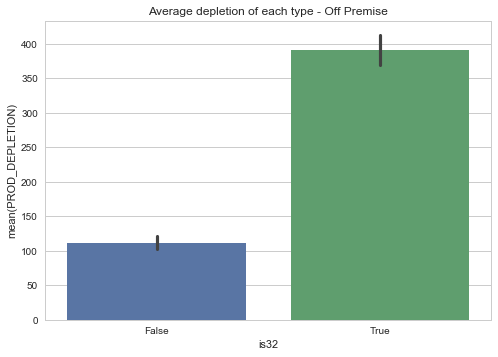

In [49]:
# Average depletion for 3.2 and Non 3.2 products
plt.title("Average depletion of each type - Off Premise")
sns.barplot(x='is32', y = 'PROD_DEPLETION', data=graph_DF);

C:\Users\qifan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


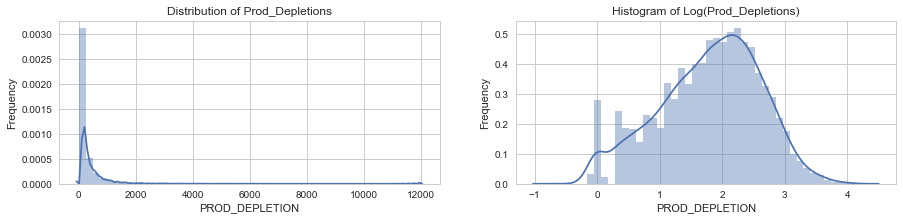

In [50]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title('Distribution of Prod_Depletions')
sns.distplot(Top5_Off_pairs_stores['PROD_DEPLETION'])
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.title('Histogram of Log(Prod_Depletions)')
sns.distplot(np.log10(Top5_Off_pairs_stores['PROD_DEPLETION'].values))
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency');

### Regression Analysis on Five products for Off-premise

In [51]:
#pair1: 'CORONA EX 3.2 12PK BT', 'CORONA EX 12PK BT'
subset1 = Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[0, :]))].reset_index(drop=True)
Regression_Off_pair1 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)', data= subset1)
print(Regression_Off_pair1.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.225
Model:                                OLS   Adj. R-squared:                  0.224
Method:                     Least Squares   F-statistic:                     557.6
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):          1.90e-108
Time:                            20:19:02   Log-Likelihood:                -3720.8
No. Observations:                    1924   AIC:                             7446.
Df Residuals:                        1922   BIC:                             7457.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------

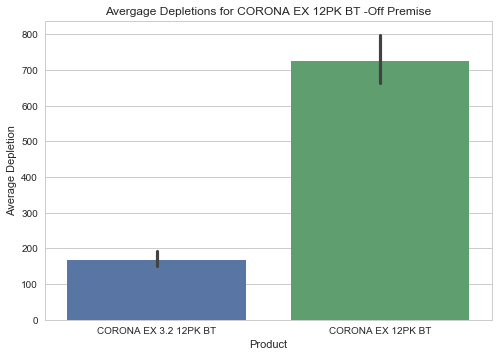

In [52]:
plt.title("Avergage Depletions for CORONA EX 12PK BT -Off Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset1)
graph.set(xlabel='Product', ylabel='Average Depletion');

In [53]:
#pair2: 'CORONA EX 3.2 6PK BT', 'CORONA EX 6PK BT'
subset2 = Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[1, :]))].reset_index(drop=True)
Regression_Off_pair2 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)', data= subset2)
print(Regression_Off_pair2.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.149
Model:                                OLS   Adj. R-squared:                  0.149
Method:                     Least Squares   F-statistic:                     428.8
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):           6.55e-88
Time:                            20:21:13   Log-Likelihood:                -4357.5
No. Observations:                    2448   AIC:                             8719.
Df Residuals:                        2446   BIC:                             8731.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------

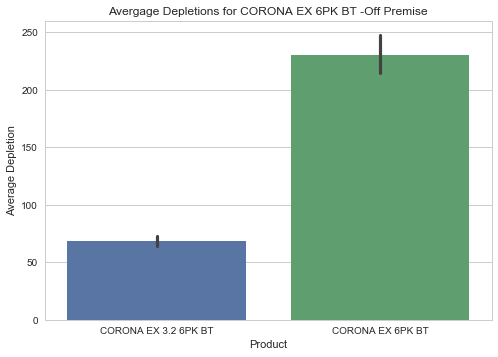

In [54]:
plt.title("Avergage Depletions for CORONA EX 6PK BT -Off Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset2)
graph.set(xlabel='Product', ylabel='Average Depletion');

In [55]:
#pair3: 'MODELO ESP 3.2 12PK CAN', 'MODELO ESP 12PK CAN'
subset3 = Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[2, :]))].reset_index(drop=True)
Regression_Off_pair3 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)', data= subset3)
print(Regression_Off_pair3.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.040
Model:                                OLS   Adj. R-squared:                  0.039
Method:                     Least Squares   F-statistic:                     53.48
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):           4.55e-13
Time:                            20:22:35   Log-Likelihood:                -2711.9
No. Observations:                    1301   AIC:                             5428.
Df Residuals:                        1299   BIC:                             5438.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------

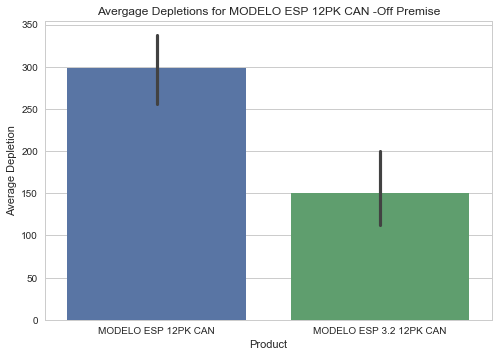

In [56]:
plt.title("Avergage Depletions for MODELO ESP 12PK CAN -Off Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset3)
graph.set(xlabel='Product', ylabel='Average Depletion');

In [57]:
#pair4: 'CORONA EX 3.2 18PK BT', 'CORONA EX 18PK BT'
subset4 = Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[3, :]))].reset_index(drop=True)
Regression_Off_pair4 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)', data= subset4)
print(Regression_Off_pair4.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.023
Model:                                OLS   Adj. R-squared:                  0.022
Method:                     Least Squares   F-statistic:                     22.39
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):           2.56e-06
Time:                            20:23:46   Log-Likelihood:                -2011.8
No. Observations:                     945   AIC:                             4028.
Df Residuals:                         943   BIC:                             4037.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------

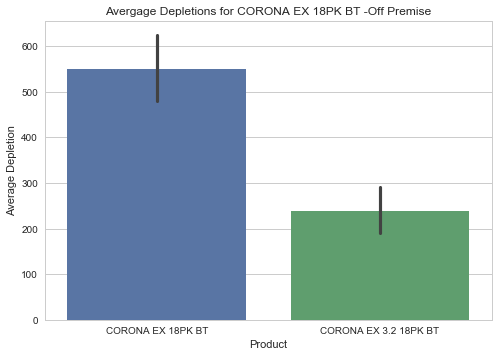

In [58]:
plt.title("Avergage Depletions for CORONA EX 18PK BT -Off Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset4)
graph.set(xlabel='Product', ylabel='Average Depletion');

In [59]:
#pair5: 'MODELO ESP 3.2 6PK BT', ' MODELO ESP 6PK BT'
subset5 = Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[4, :]))].reset_index(drop=True)
Regression_Off_pair5 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)', data= subset5)
print(Regression_Off_pair5.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.116
Model:                                OLS   Adj. R-squared:                  0.116
Method:                     Least Squares   F-statistic:                     219.1
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):           1.17e-46
Time:                            20:24:33   Log-Likelihood:                -3146.3
No. Observations:                    1667   AIC:                             6297.
Df Residuals:                        1665   BIC:                             6307.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------

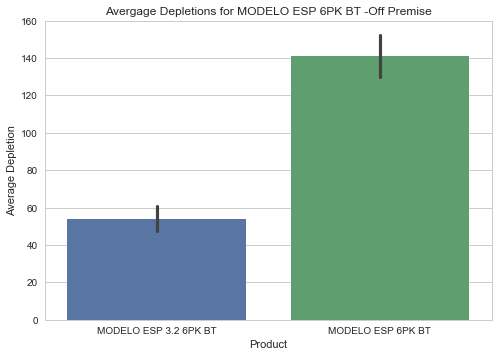

In [62]:
plt.title("Avergage Depletions for MODELO ESP 6PK BT -Off Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset5)
graph.set(xlabel='Product', ylabel='Average Depletion');